In [1]:
from src import *

## Table of Contents
- [Timeseries Comparison](#comparison)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

We have choices to either compute correlation between subjects and aggregated emotions or group level and aggregated emotions. We as well introduce other movies for the same subject in order to do permutation testing.

In [24]:
# Loading Gradient Example
networks = list(index2region.keys())
moviename = 'Chatter'
# tmp = load('./resources/dynamic_grad/individual_level/Chatter_grad.pkl')
# G_movie, varM = tmp['S30']
G_movie, varM = load('./resources/dynamic_grad/group_level/{}_40_grad.pkl'.format(moviename))
# Loading Matching Emotion Track
full_df  = pd.read_csv('./data/emoFiles/emotion_compile.csv')
emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

We use the following 4 metrics:
- network variance/position
- network volume
- intra-network distances
- explained variance from eigendecomposition

Text(0.5, 0.98, 'Metrics evaluations')

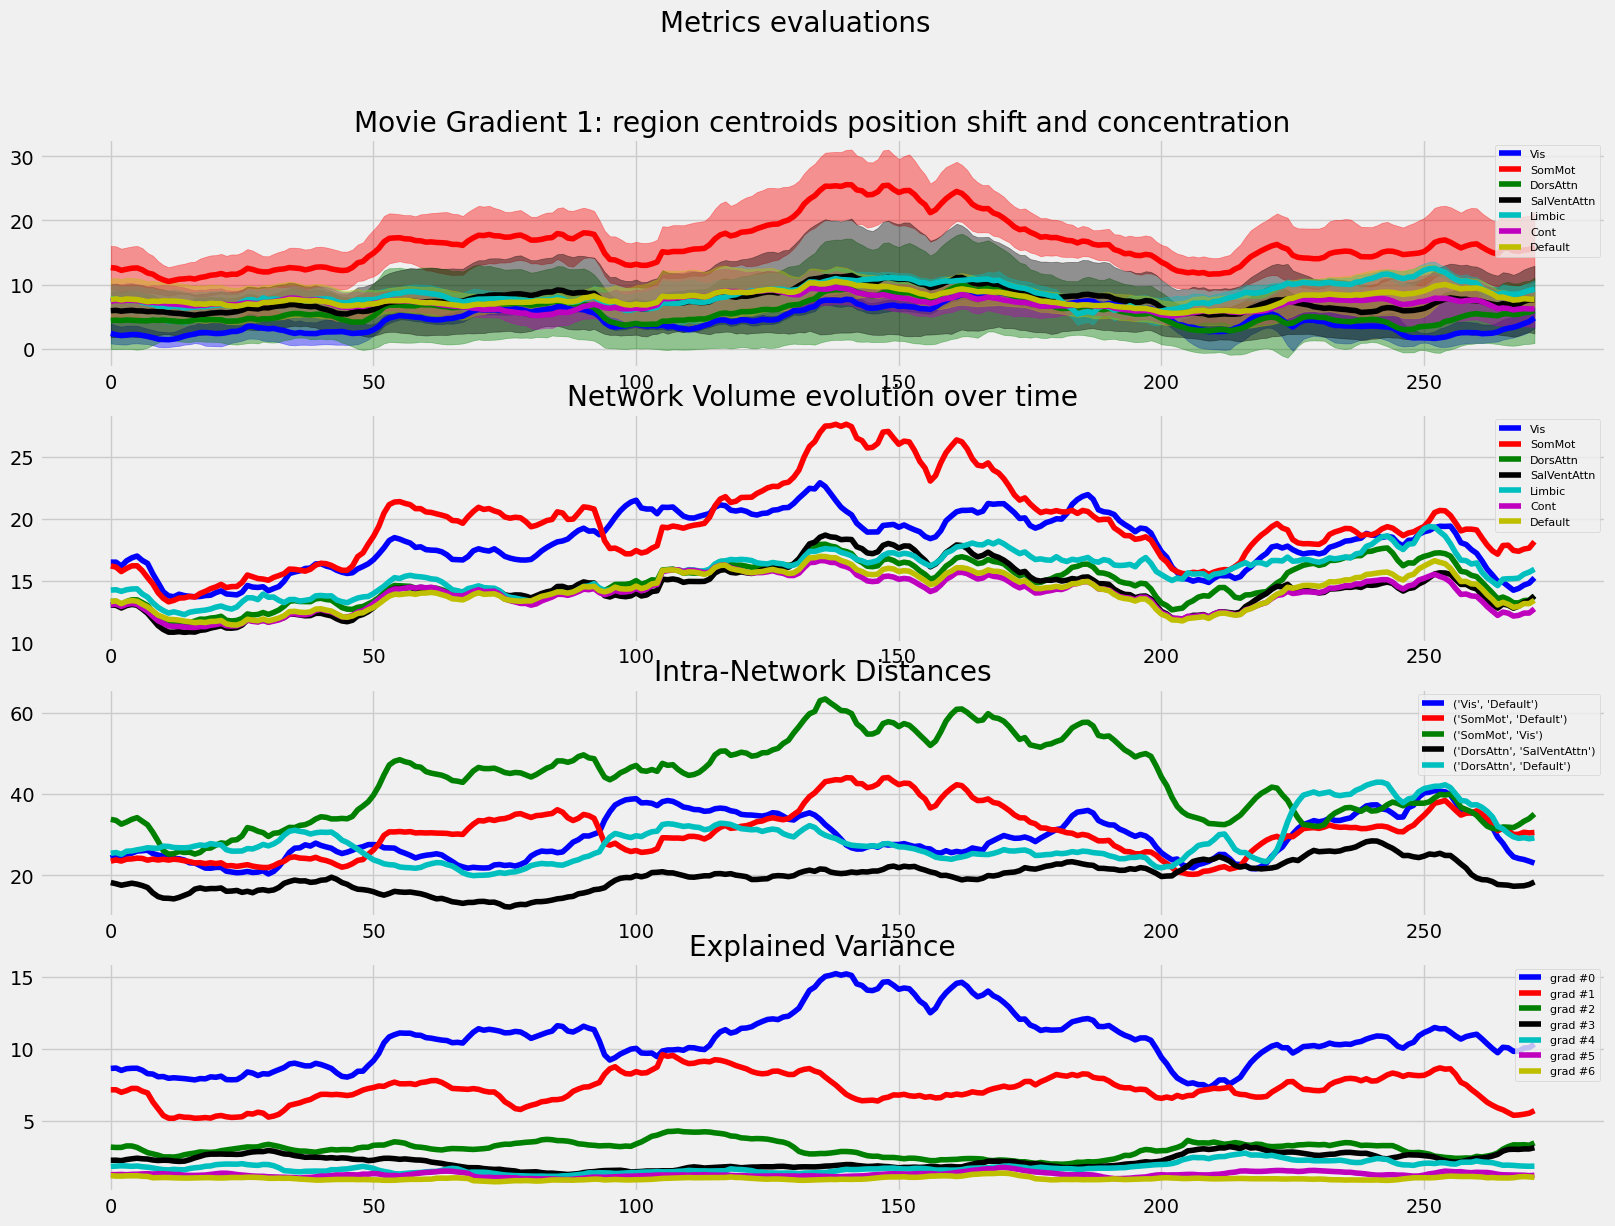

In [25]:
wash  = 93.9/ TR # duration in seconds for wash is 93.9 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec

n = len(networks)
# fig, ax = plt.subplots(n, 1,figsize=(15,5))
fig, ax = plt.subplots(4,1,figsize=(18,13))

# METRIC 1
grad_idx = 0
for idx, R in enumerate(networks):
    y = network_position(G_movie, R, grad_idx)
    x = np.arange(len(y))
    error = network_variance(G_movie, R, grad_idx)

    # ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    # ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    # ax[idx].axvline(x=wash, label='after wash')
    # ax[idx].legend(loc=1)

    ax[0].plot(x,y, color=PALETTE[idx], label=R)
    ax[0].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[0].legend(loc=1, prop={'size':8})    
    # ax[idx].set_ylim(0, 30)
# ax[0].axvline(x=wash, label='after wash')
ax[0].set_title("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

# METRIC 2
for idx, R in enumerate(networks):
    
    y = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))

    ax[1].plot(x,y, color=PALETTE[idx], label=R)
    # ax[1].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[1].legend(loc=1, prop={'size':8})    
    # ax[idx].set_ylim(0, 30)
# ax[1].axvline(x=wash, label='after wash')
ax[1].set_title("Network Volume evolution over time")

# METRIC 3
pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default")]

for idx, pair in enumerate(pairs):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))
    ax[2].plot(x,y, color=PALETTE[idx], label=pair)
    # ax[1].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[2].legend(loc=1, prop={'size':8}) 
ax[2].set_title("Intra-Network Distances")   

# METRIC 4
for idx, gradnb in enumerate(range(varM.shape[1]-3)):
    y = varM[:,gradnb]
    x = np.arange(len(y))
    ax[3].plot(x,y, color=PALETTE[idx], label='grad #{}'.format(gradnb))
    # ax[1].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[3].legend(loc=1, prop={'size':8}) 
ax[3].set_title("Explained Variance") 

plt.suptitle("Metrics evaluations".format(grad_idx + 1), size=20)

Text(0.5, 1.0, 'Aggregated Emotion time series')

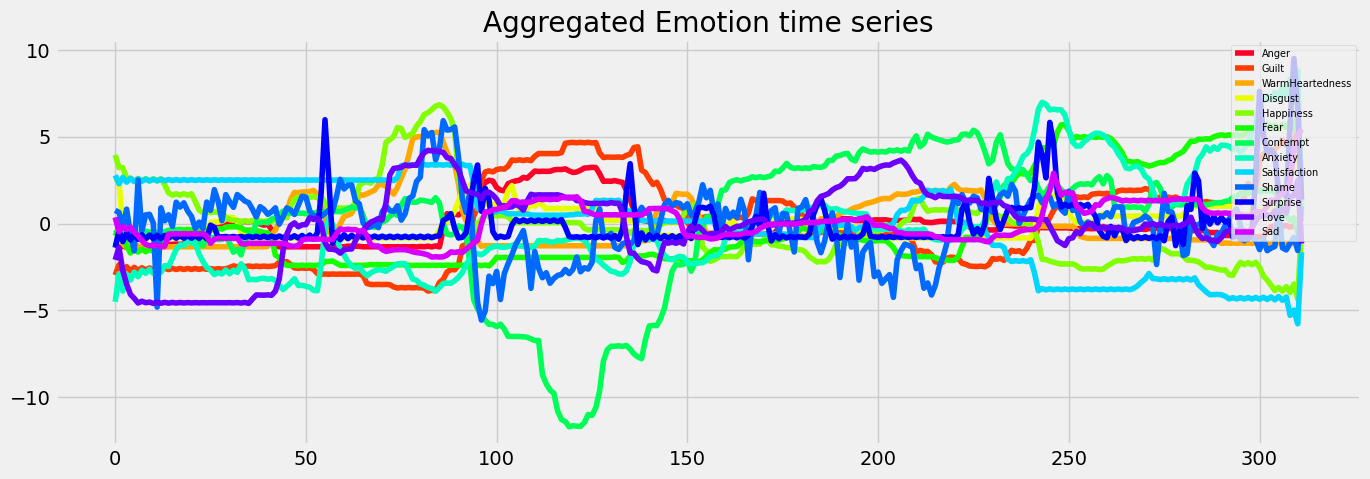

In [26]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

NUM_COLORS = len(select)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    ax.plot(emo_series, label=emotion)

ax.legend(loc=1, prop={'size':7})
ax.set_title("Aggregated Emotion time series")

Compute correlation between a given metric and emotion series

In [32]:
def moviemix_stat_test(totest, mainseries, mixseries):
    # Obtained sample correlation
    mainseries = overlap_add(mainseries, 1)
    m          = min(len(totest), len(mainseries))
    cur,_,_    = correlation_search(zscore(totest[:m]), zscore(mainseries[:m]), 0, 1)

    # generate null distribution
    ndistrib = []
    for i in range(len(mixseries) - len(totest)):
        b = mixseries[i:i+len(totest)]
        b = overlap_add(b, 1)
        a, b = zscore(totest), zscore(b)
        corr, _,_ = correlation_search(a,b, 0, 1)
        ndistrib.append(corr)

    ndistrib = np.asarray(ndistrib)
    nscore   = null_score(ndistrib, cur)
    return ndistrib, nscore, cur

In [35]:
# Grid for each network of correlation with emotions
grad_idx = 0
smfactor = 1
tolshift = 0


n = len(networks)
m = len(select)

pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default")]
nb_metric = 4
scores  = np.zeros((nb_metric, n,m))
nscores = np.zeros((nb_metric, n,m))

# METRIC 1
for idx, pair in enumerate(tqdm(pairs)):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)
    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        # corr = correlation_search(z1,z2, tolshift)
        # scores[0, idx,jdx] = corr
        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[0, idx,jdx] = nscore
        scores[0, idx,jdx]  = corr           

# METRIC 2
for idx, R in enumerate(networks):
    # Metric we use here would be variance of a cluster
    y  = network_variance(G_movie, R, grad_idx)
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        # corr = correlation_search(z1,z2, tolshift)
        # scores[1, idx,jdx] = corr
        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[1, idx,jdx] = nscore
        scores[1, idx,jdx]  = corr        
    
# METRIC 3
for idx, R in enumerate(networks):
    y  = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        # corr = correlation_search(z1,z2, tolshift)
        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[2, idx,jdx] = nscore
        scores[2, idx,jdx]  = corr

# METRIC 4
for idx, R in enumerate(networks):
    y  = varM[:,idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        # corr = correlation_search(z1,z2, tolshift)
        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[3, idx,jdx] = nscore
        scores[3, idx,jdx]  = corr


100%|██████████| 7/7 [02:23<00:00, 20.47s/it]


In [36]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores2[idx,jdx] = corr

100%|██████████| 400/400 [00:05<00:00, 67.22it/s]


#### Correlation brain maps with 7 networks
We select here the max and visualize how well they correlate each other

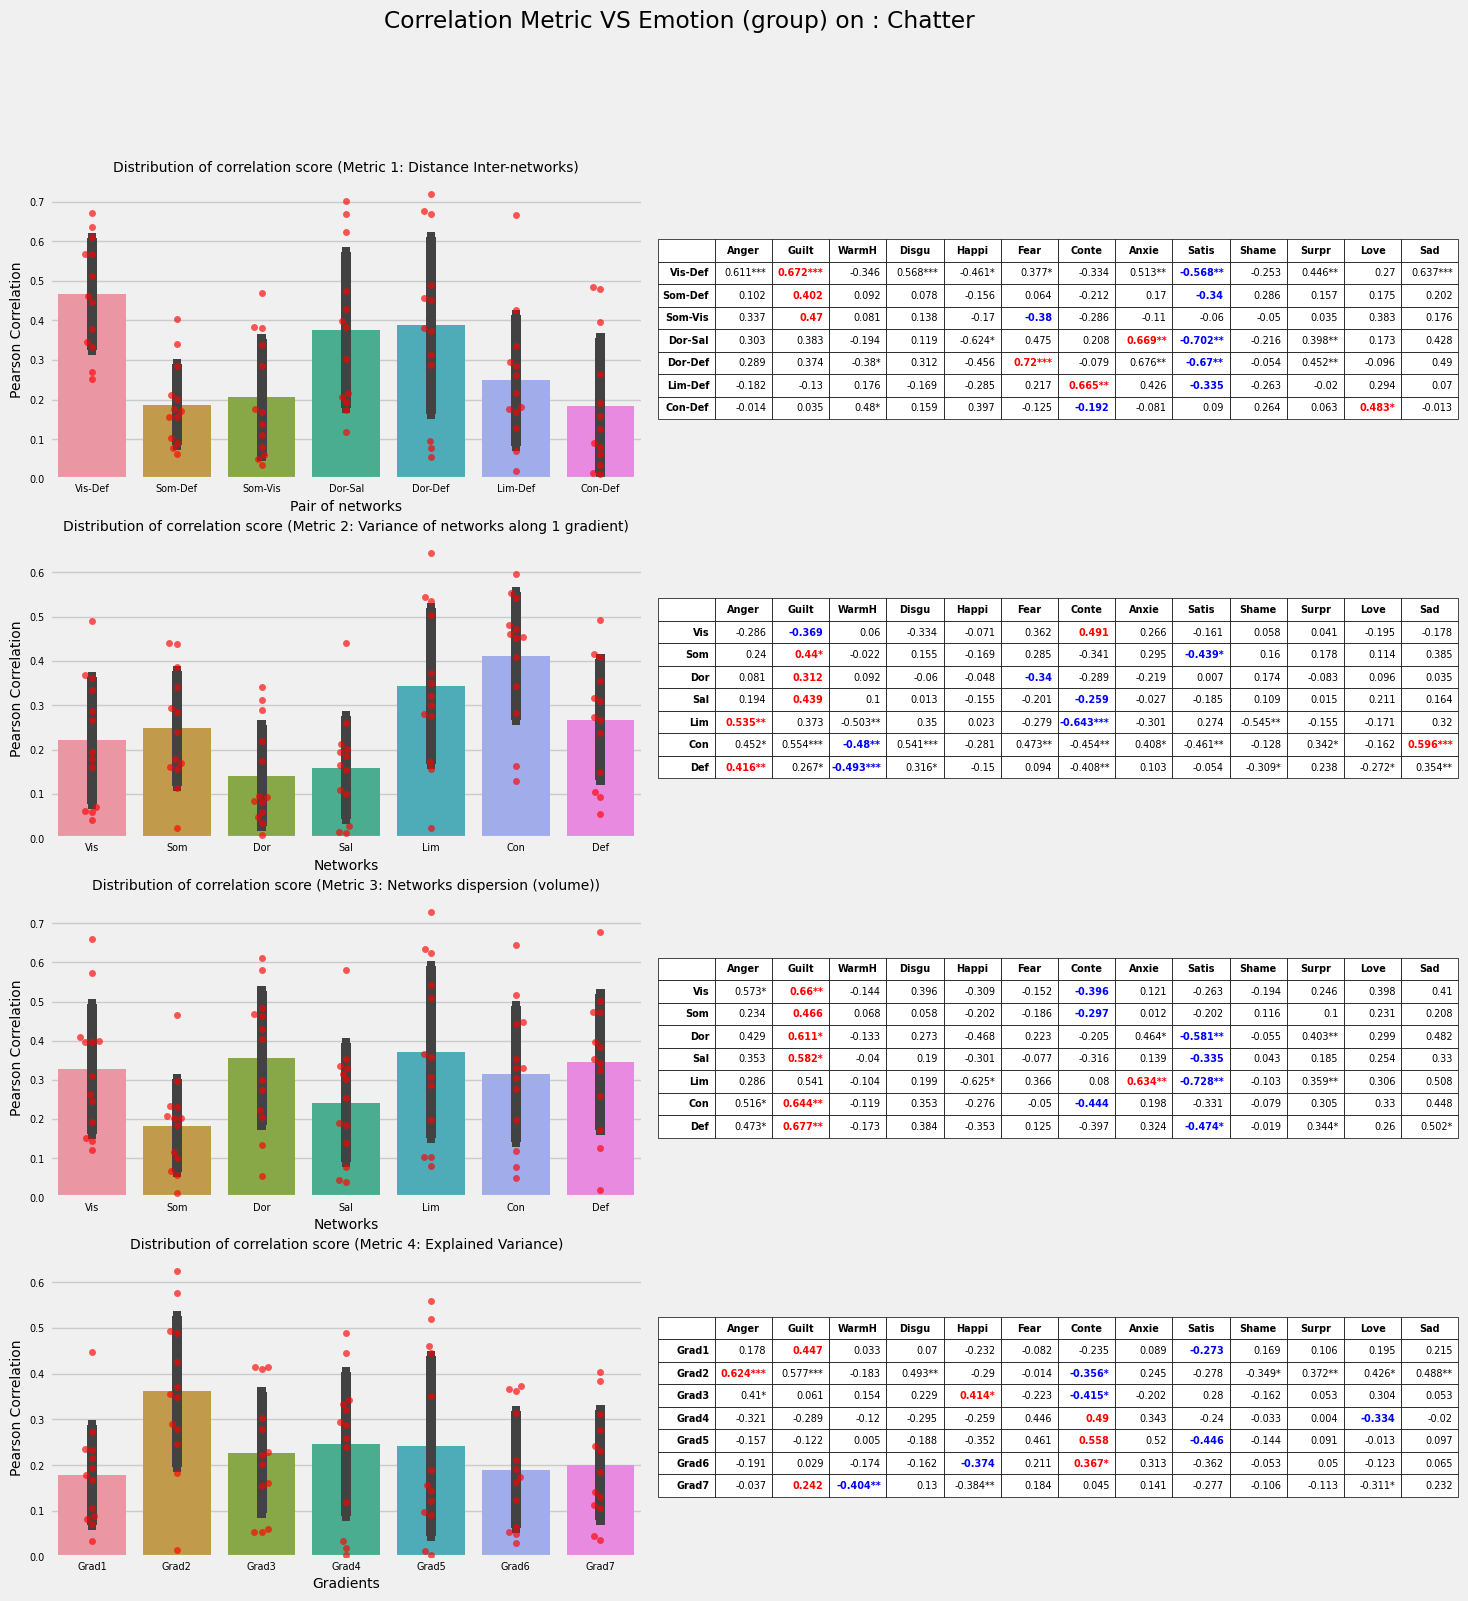

In [49]:
from matplotlib.font_manager import FontProperties

xlabels = ["Pair of networks", "Networks", "Networks", "Gradients"]
titles  = ["Distribution of correlation score (Metric 1: Distance Inter-networks)",
            "Distribution of correlation score (Metric 2: Variance of networks along 1 gradient)",
            "Distribution of correlation score (Metric 3: Networks dispersion (volume))",
            "Distribution of correlation score (Metric 4: Explained Variance)"]
fig,ax = plt.subplots(nb_metric,2,figsize=(15,17))
for m in range(nb_metric):
    # MAKING TABLE
    tabling = np.empty((7,14), dtype=np.object_)
    for j in range(14):
        for i in range(7):
            if j == 0:
                if m == 0:
                    p1,p2 = pairs[i] 
                    tabling[i,j] = p1[:3] + '-' + p2[:3]
                elif m == 3:
                    tabling[i,j] = 'Grad{}'.format(i+1)
                else:
                    tabling[i,j] = networks[i][:3]
            else:
                tabling[i,j] = np.object_(np.round(scores[m][i,j-1],3))

    concat_region = np.concatenate([[r] * scores[m].shape[1] for r in tabling[:,0]])
    corr_score = {'networks': concat_region, 'mean-corr': np.abs(scores[m].flatten())}

    sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
    sns.swarmplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, color="r", alpha=.65)
    ax[m,0].set_title(titles[m], size=10)
    ax[m,0].tick_params(labelsize=7)
    ax[m,0].set_xlabel(xlabels[m], size=10)
    ax[m,0].set_ylabel('Pearson Correlation', size=10)

    ax[m,1].axis('tight')
    ax[m,1].axis('off')

    table = ax[m,1].table(cellText=tabling,
                            colLabels=[''] + [s[:5] for s in select],
                            loc='center')

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        if (col == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        
        # stress on which values is large
        if (np.argmax(scores[m][row-1]) == col - 1) and row !=0 :
            cell.get_text().set_color('red')
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        if (np.argmin(scores[m][row-1]) == col - 1) and row !=0 :
            cell.get_text().set_color('blue')
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

        # stress on which value is significant against null distribution
        nscore  = nscores[m, row-1, col - 1]
        nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)
        
        if row != 0 and col !=0 :
            cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)

    
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.35, 1.35)  # may help                        

plt.suptitle("Correlation Metric VS Emotion (group) on : {}".format(moviename))
plt.show()

For Metric 5: we monitor each parcels/regions separately 

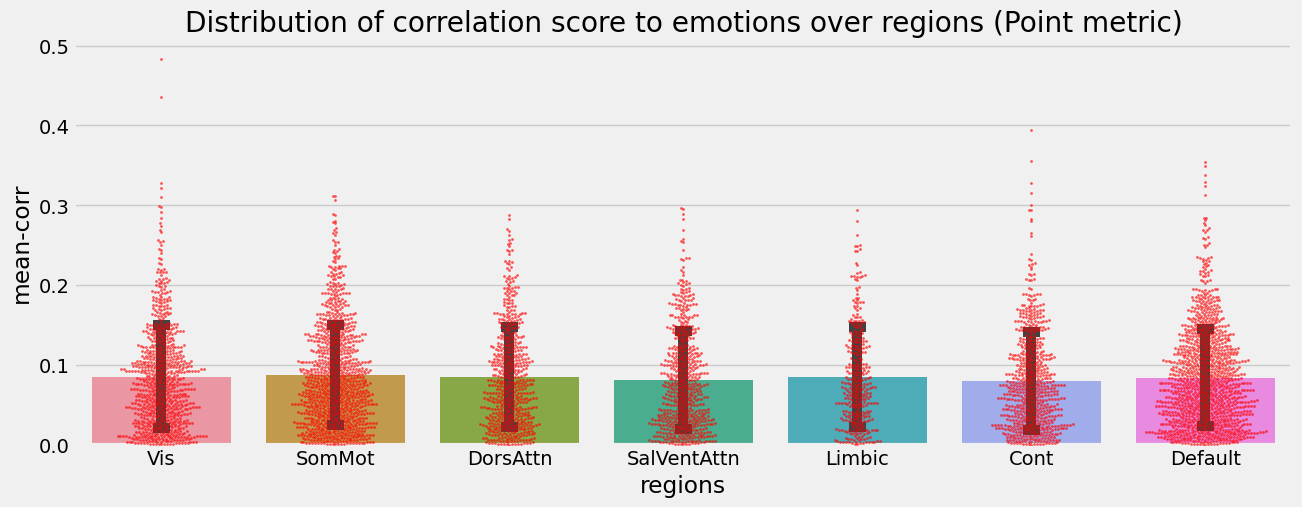

In [38]:
partial_region = load('./resources/region400yeo7.pkl')
partial_region = list(partial_region.values())

concat_region = np.concatenate([partial_region * scores2.shape[1]])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores2.flatten())}
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="r", alpha=.65, size=2)
plt.title("Distribution of correlation score to emotions over regions (Point metric)")
plt.show()

Direct series visualization comparison (check)

In [57]:
print(scores[0].argmax()//13, scores[0].argmax()%13 )
print(scores[1].argmax()//13, scores[1].argmax()%13 )
print(scores[2].argmax()//13, scores[2].argmax()%13 )

4 5
5 12
6 1


(0.7195203396482284, (0, 0), 1.185799154026803e-44)


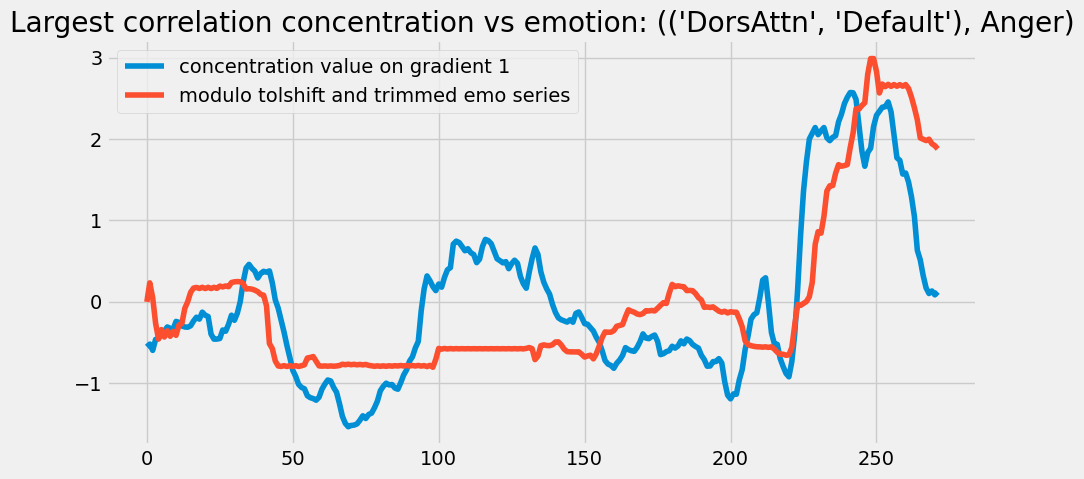

In [51]:
# METRIC 1
p1,p2 = pairs[4]
y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                for t in range(len(G_movie))])
z1 = zscore(y)
emo_series = np.array(emo_df[emo_df.item==select[5]]['score'])
smoothened = overlap_add(emo_series, smfactor)
z2   = zscore(smoothened[:z1.shape[0]])
corr = correlation_search(z1,z2, tolshift)
print(correlation_search(z1,z2, 0, 1))
plt.figure(figsize=(10,5))
plt.plot(z1, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(z2, label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(pairs[4],select[0]))
plt.legend()

(0.5960519434877791, (0, 0), 1.489410387112635e-27)


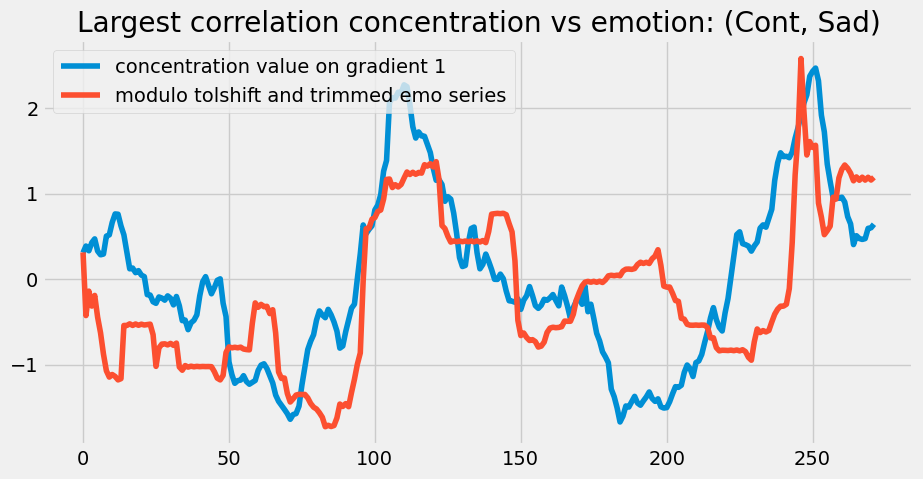

In [54]:
idxa = 5
idxb = 12

a = network_variance(G_movie, networks[idxa], grad_idx)
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(networks[idxa],select[idxb]))
plt.legend()

(0.6335379058113073, (0, 0), 6.282041810263337e-32)


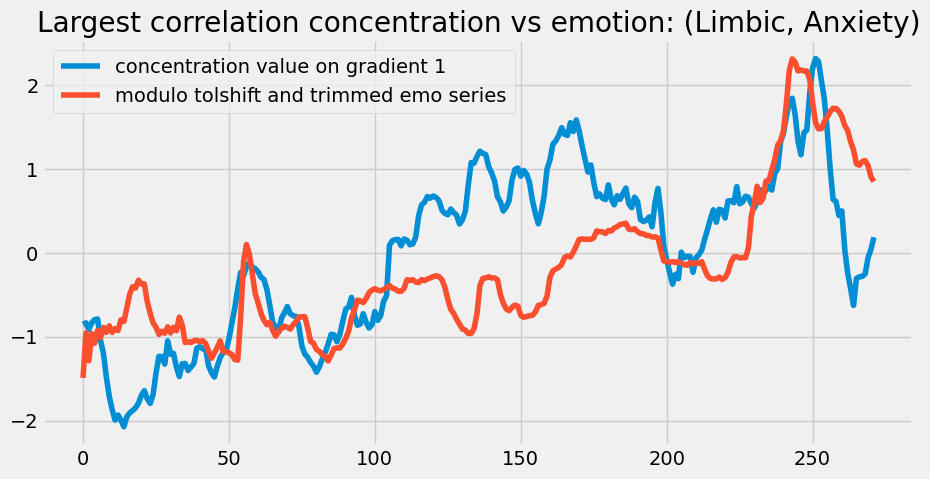

In [59]:
idxa = 4
idxb = 7

a  = np.asarray([network_volume(G_movie[t], networks[idxa]) 
                    for t in range(len(G_movie))])
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(networks[idxa],select[idxb]))
plt.legend()


(0.6765341039046935, (0, 0), 9.467053084572574e-38)


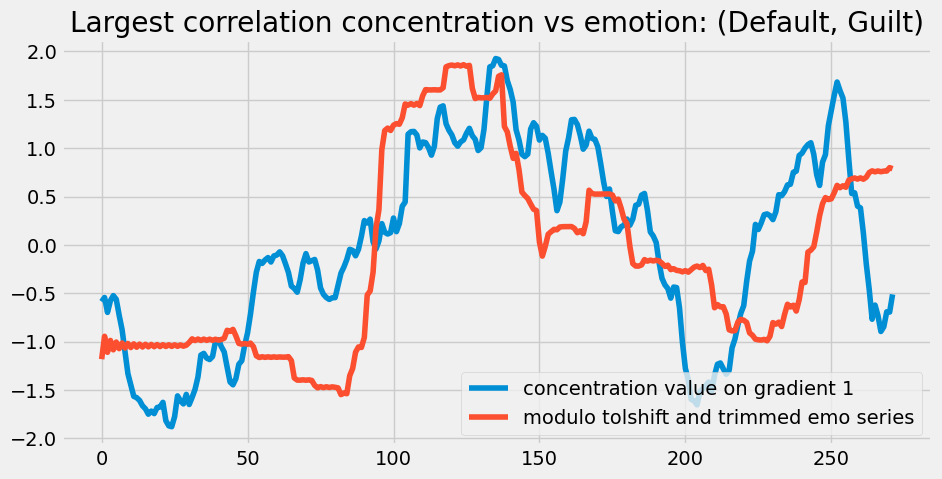

In [60]:
idxa = -1
idxb = 1

a  = np.asarray([network_volume(G_movie[t], networks[idxa]) 
                    for t in range(len(G_movie))])
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(networks[idxa],select[idxb]))
plt.legend()

In [ ]:
# # Uncomment for: Sanity Check of Eigenvector explained variances
# plot_eigenvector_importance(g_movie)
# plot_eigenvector_importance(g_rest)

#### Correlation brain maps with 400 parcellations

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


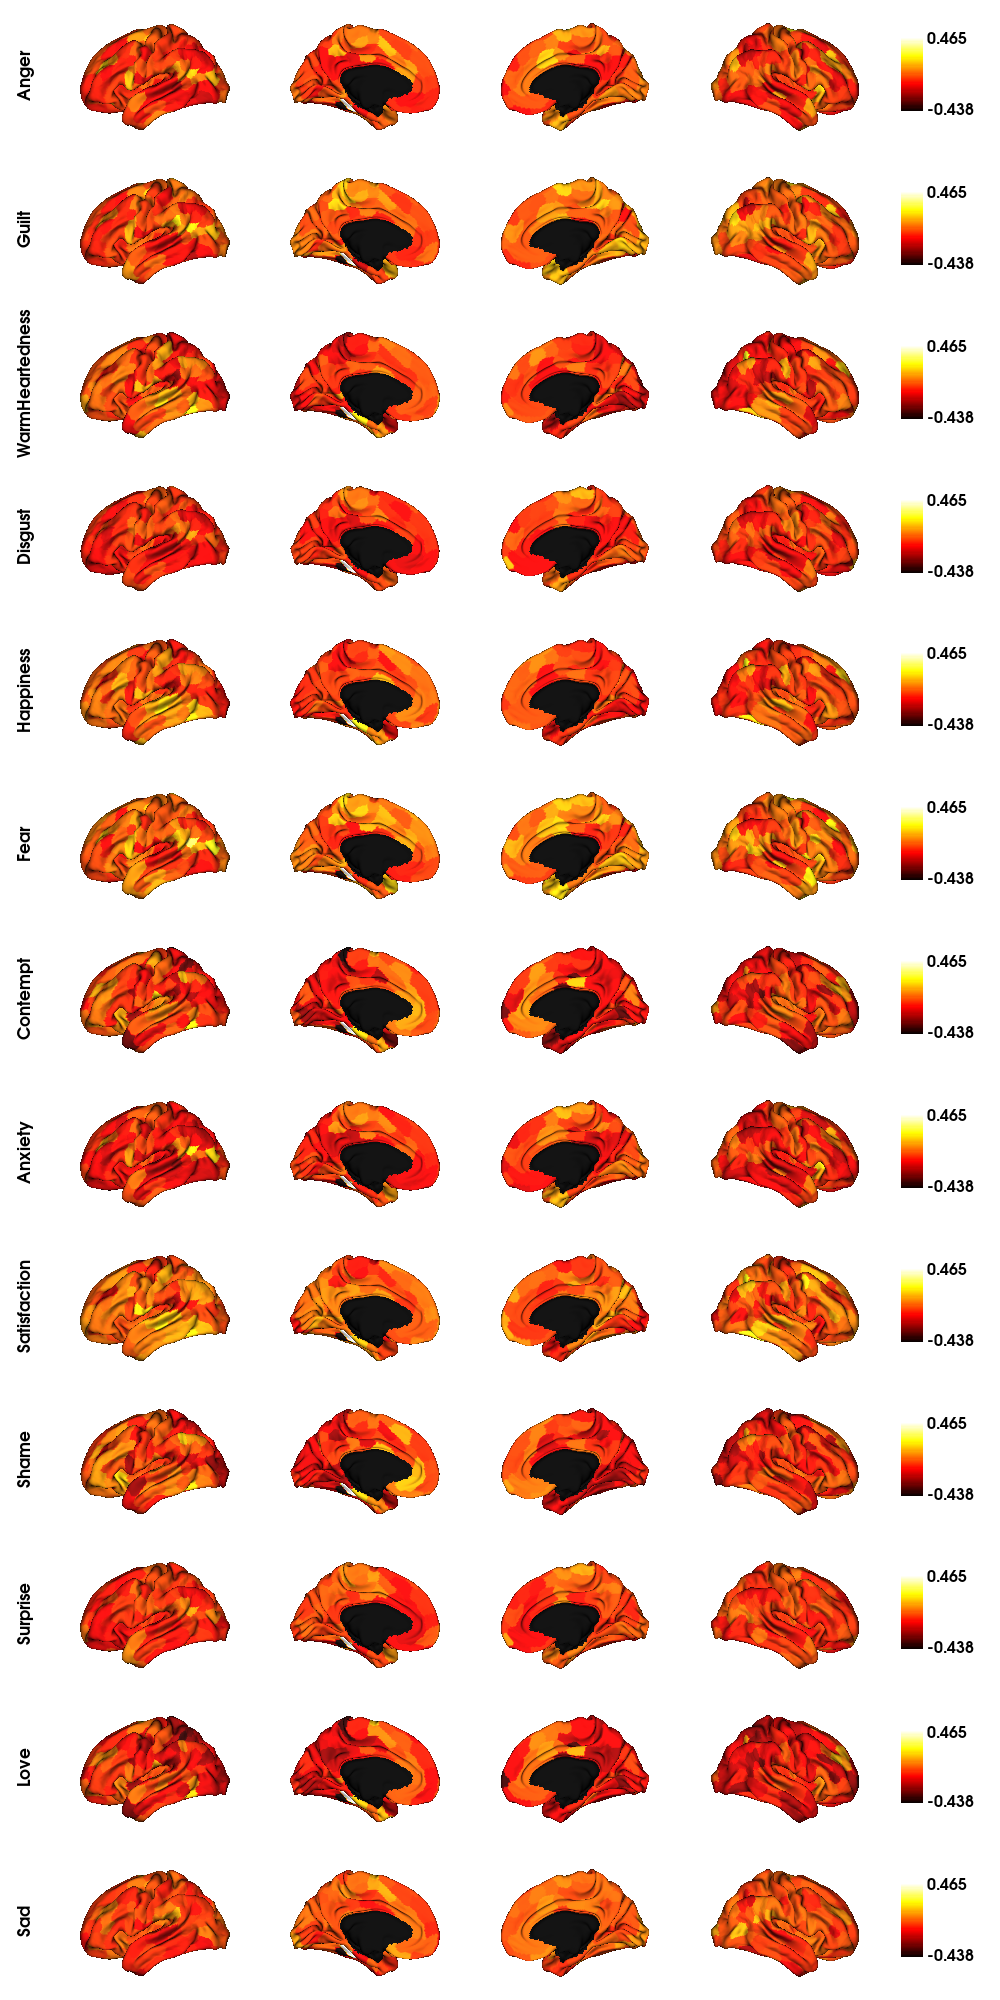

In [126]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = deepcopy(scores2.T)

grad = [None] * len(select)
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    gs[k][0]   = gs.min()
    gs[k][1]   = gs.max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='hot',
                 color_bar=True, label_text=select, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


#### Permutation Testing
TODO: for multiple pair emotions netowrk plot the null distributions

In [35]:
idxa = 5
idxb = 11

other_df = full_df[full_df.filename != 'W_Sintel13.csv']
order2 = list(other_df.filename.unique())
np.random.shuffle(order2)

concat_other  = np.array(other_df[other_df.item == select[idxb]]['score'])
concat_other2 = np.concatenate([other_df[(other_df.item == select[idxb]) & 
                            (other_df.filename == o)].score for o in order2])

In [36]:
# Obtained sample correlation
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)
cur,_,_ = correlation_search(zscore(a), zscore(b[:len(a)]), 0, 1)

In [18]:
discrete = []
for o in order2:
    f = other_df[(other_df.item == select[idxb]) & (other_df.filename == o)].score
    f = overlap_add(f, 1)
    m = min(len(f), len(a))
    corr,_,_ = correlation_search(zscore(a)[:m], zscore(f[:m]), 0, 1)
    discrete.append(corr)

In [40]:
# from mlxtend.evaluate import permutation_test
# permutation_test(a , c, method='approximate', num_rounds=10000, func=lambda x,y: np.corrcoef(x,y)[1][0], seed=0)

# another order of emotions series
null_distrib3 = []
for i in range(len(concat_other2) - len(a)):
    e = concat_other2[i:i+len(a)]
    e = overlap_add(e, 1)
    a, e = zscore(a), zscore(e)
    corr, _,_ = correlation_search(a,e, 0, 1)
    null_distrib3.append(corr)

# default order of emotions series
null_distrib2 = []
for i in range(len(concat_other) - len(a)):
    d = concat_other[i:i+len(a)]
    d = overlap_add(d, 1)
    a, d = zscore(a), zscore(d)
    corr, _,_ = correlation_search(a,d, 0, 1)
    null_distrib2.append(corr)

# shuffling gradient metrics series
np.random.seed(10)
nb_shuffle = 10000
samples = np.zeros((nb_shuffle, len(a)))
for i in range(nb_shuffle):
    ashuffle = deepcopy(a)
    np.random.shuffle(ashuffle)
    samples[i] = ashuffle

c = b[:a.shape[0]]

null_distrib = []
for i in range(len(samples)):
    null_distrib.append(correlation_search(samples[i], c, 0, 1)[0])


Might not be best permutation test as can be seen here in the another movie we obtain basically the same correlation strength. Careful to always to this plot to verify.

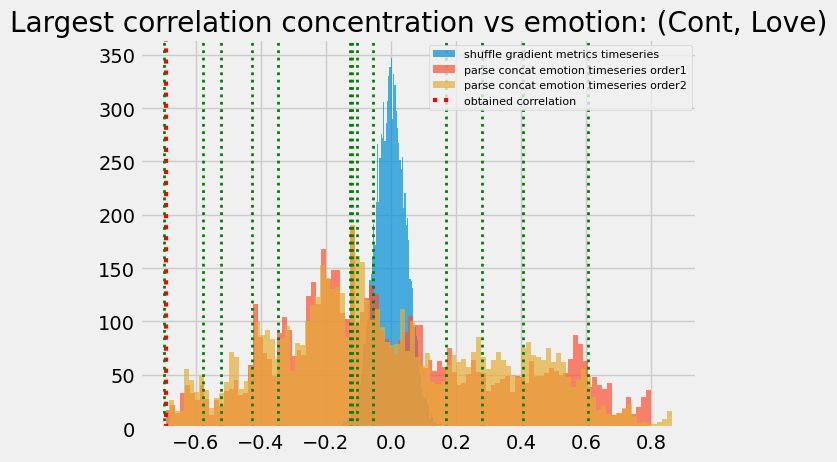

In [50]:
plt.hist(null_distrib, bins=100, alpha=0.7, label="shuffle gradient metrics timeseries")
plt.hist(null_distrib2, bins=100, alpha=0.7, label="parse concat emotion timeseries order1")
plt.hist(null_distrib3, bins=100, alpha=0.7, label="parse concat emotion timeseries order2")
plt.axvline(x=cur, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
for k in range(len(discrete)):
    plt.axvline(x=discrete[k], c='g', linestyle='dotted', linewidth=2)
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend(loc=1, prop={'size':8})

In [56]:
def plot_nulldistribution(totest, mainseries, mixseries):
    ndistrib,nscore = moviemix_stat_test(totest, mainseries, mixseries)
    
    plt.hist(ndistrib, bins=100, alpha=0.7, label="null distribution")
    plt.axvline(x=nscore, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
    plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
    plt.legend(loc=1, prop={'size':8})
    plt.show()

In [57]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))
conf    = np.zeros((n,m))


other_df = full_df[full_df.filename != 'W_Sintel13.csv']

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series   = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened   = overlap_add(emo_series, smfactor)
        z2           = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)

        scores2[idx,jdx] = corr
        conf[idx,jdx] = nscore

 27%|██▋       | 109/400 [42:03<1:53:00, 23.30s/it]